In [25]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [26]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
import h5py

tf.keras.backend.set_floatx('float32')

In [27]:
colab_flag = False

FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [28]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [29]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [30]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/KS


In [31]:
from tools.misc_tools import mytimecallback, SaveLosses, plot_losses, readAndReturnLossHistories, plot_reconstructed_data_KS, plot_latent_states_KS 
from tools.ae_v6 import Autoencoder

In [32]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpointAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [33]:
# setting seed for PRNGs
if behaviour == 'initialiseAndTrainFromScratch':
    prng_seed = 42
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [34]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


In [35]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print(tf.config.list_logical_devices())
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
2.8.1


# KS System

In [36]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # loading data directory
    data_dir_idx = '005'

    # making ae save directory
    dir_name_ae = os.getcwd() + dir_sep + 'saved_ae'
    if not os.path.isdir(dir_name_ae):
        os.makedirs(dir_name_ae)

    counter = 0
    while True:
        dir_check = 'ae_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ae + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ae = dir_name_ae + dir_sep + dir_check
    os.makedirs(dir_name_ae)
    os.makedirs(dir_name_ae+dir_sep+'plots')
else:
    # some paramaters
    dir_name_ae = os.getcwd()+'{ds}saved_ae{ds}ae_015'.format(ds=dir_sep)

    with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
        lines = f.readlines()

    params_dict = eval(''.join(lines))
    data_dir_idx = params_dict['data_dir_idx']
    normalizeforae_flag = params_dict['normalizeforae_flag']
    normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
    if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
        with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
            normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]

print('dir_name_ae:', dir_name_ae)
# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']

dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057
normalize_flag_ogdata: False


In [37]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [38]:
def plot(
        boundary_idx_arr,
        delta_t,
        all_data,
        xgrid,
        xticks_snapto=20,
        num_yticks=11,
        save_dir=None,
        xlabel=r'Time',
        ylabel=r'$x$',
        ax_titles_list=None
    ):

    n = len(boundary_idx_arr)
    num_digits_n = int(np.log10(n)+1)

    # '''
    num_cols = 1
    num_rows = 1
    factor = 1
    # fig = plt.figure(figsize=(7.5*num_cols, 7.5*num_rows))

    num_modes = xgrid.shape[0]

    prev_idx = 0
    for i in range(len(boundary_idx_arr)):
        next_idx = boundary_idx_arr[i]
        fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
        N = next_idx - prev_idx
        input_time = np.arange(0, N)*delta_t

        im = ax.imshow(all_data[prev_idx:next_idx, 0:num_modes].transpose(), aspect='auto', origin='lower')
        num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
        # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
        xticks = np.arange(0, N, int((xticks_snapto+0.5*delta_t)//delta_t))
        ax.set_xticks(ticks=xticks)
        ax.set_xticklabels(np.round(xticks*delta_t, 1))
        ax.tick_params(axis='x', rotation=270+45)

        yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
        yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
        ax.set_yticks(ticks=yticks)
        ax.set_yticklabels(yticklabels)

        ax.set_xlabel('Time')
        ax.set_ylabel(r'$x$')
        # ax.title.set_text(r'Latent States')
        if ax_titles_list is not None:
            ax.title.set_text(ax_titles_list[i])
        else:
            ax.title.set_text(r'Case '+str(i+1))

        plt.colorbar(im)
        if save_dir is not None:
            fig.savefig(save_dir+'/Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
            fig.clear()
            plt.close()
        else:
            plt.show()
            print('')

        prev_idx = next_idx

    # '''

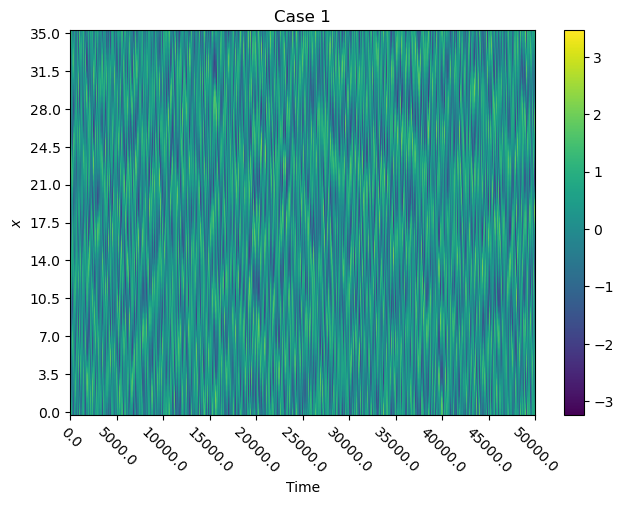

In [39]:
temp = boundary_idx_arr[0] + np.sum(boundary_idx_arr[1:] - boundary_idx_arr[0:-1])
temp /= len(boundary_idx_arr)
temp *= delta_t
chosen_interval = temp//10
sn = np.format_float_scientific(chosen_interval, exp_digits=4)
snap = np.max([0.1, 25*np.round(10*float(sn[0:-6])/25)/10])
snap *= float('1'+sn[-6:])
xticks_snapto = int(snap*np.round(chosen_interval/snap))

plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

In [40]:
# dealing with normalizing the data before feeding into autoencoder
if behaviour == 'initialiseAndTrainFromScratch':
    # normalize data before feeding into autoencoder?
    normalizeforae_flag = True
    normalization_type = 'stddev' # could be 'stddev' or 'minmax'
    stddev_multiplier = 3
    
    ae_data_with_params = False # whether to feed in the parameters to the AE along with the data?

    normalization_constant_arr_aedata = None
    if normalizeforae_flag == True:
        normalization_constant_arr_aedata = np.empty(shape=(2, numpoints_xgrid), dtype=FTYPE)
        if normalization_type == 'stddev':
            for i in range(numpoints_xgrid):
                sample_mean = np.mean(all_data[:, i])
                sample_std = np.std(all_data[:, i])
                normalization_constant_arr_aedata[0, i] = sample_mean
                normalization_constant_arr_aedata[1, i] = stddev_multiplier*sample_std
        elif normalization_type == 'minmax':
            for i in range(numpoints_xgrid):
                sample_min = np.min(all_data[:, i])
                sample_max = np.max(all_data[:, i])
                if sample_max - sample_min == 0:
                    sample_min = sample_min - 0.5
                    sample_max = sample_min + 1
                normalization_constant_arr_aedata[0, i] = sample_min
                normalization_constant_arr_aedata[1, i] = sample_max - sample_min
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
    # saving sim data
    ae_data = {
        'data_dir_idx':data_dir_idx,
        'normalizeforae_flag':normalizeforae_flag,
        'normalization_constant_arr_aedata':normalization_constant_arr_aedata,
        'normalization_type':normalization_type,
        'stddev_multiplier':stddev_multiplier,
        'ae_data_with_params':ae_data_with_params,
        'module':Autoencoder.__module__,
    }
    with open(dir_name_ae+dir_sep+'ae_data.txt', 'w') as f:
        f.write(str(ae_data))
    np.savez(
        dir_name_ae+dir_sep+'normalization_data',
        normalization_constant_arr_aedata=[normalization_constant_arr_aedata],
    )
else:
    if normalizeforae_flag == True:
        for i in range(numpoints_xgrid):
            all_data[:, i] -= normalization_constant_arr_aedata[0, i]
            all_data[:, i] /= normalization_constant_arr_aedata[1, i]
            
time_stddev = np.std(all_data, axis=0)
if ae_data_with_params == False:
    all_data = all_data[:, 0:numpoints_xgrid]
    time_stddev = time_stddev[0:numpoints_xgrid]
else:
    time_stddev[numpoints_xgrid:] = 1.0

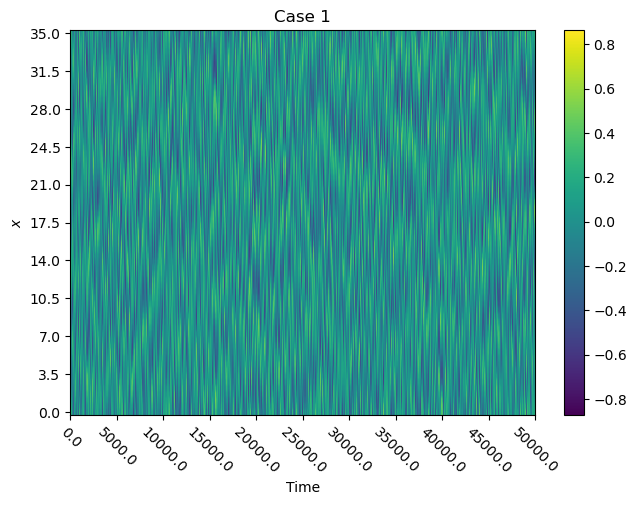

In [41]:
plot(
    boundary_idx_arr,
    delta_t,
    all_data,
    xgrid,
    xticks_snapto=xticks_snapto)

# Autoencoder

In [42]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [1e-3, 1e-4, 1e-5]
    epochs = 1000
    patience = 25  # parameter for early stopping
    min_delta = 1e-6  # parameter for early stopping
    lambda_reg = 1e-6 # weight for regularizer
    train_split = 0.8
    val_split = 0.1
    test_split = 1 - train_split - val_split
    batch_size = 64
    fRMS = 1/100
    timeMeanofSpaceRMS = np.mean(np.mean(all_data**2, axis=1)**0.5)
    
    # stddev = fRMS*timeMeanofSpaceRMS
    stddev = fRMS * np.mean(time_stddev[0:numpoints_xgrid])
    contractive_lmda = 50
    use_weights_post_dense = True
    dropout_rate = 0.02
    

    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'timeMeanofSpaceRMS':timeMeanofSpaceRMS,
        'stddev':stddev,
        'contractive_lmda':contractive_lmda,
        'dropout_rate':dropout_rate,
    }

    with open(dir_name_ae+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
else:
    with open(dir_name_ae + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        stddev = tparams_dict['stddev']
    except:
        print("'stddev' not in tparams_dict, set to 0")
        stddev = 0.0
    try:
        contractive_lmda = tparams_dict['contractive_lmda']
    except:
        print("'contractive_lmda' not in tparams_dict, set to 0")
        contractive_lmda = 0.0
    try:
        dropout_rate = tparams_dict['dropout_rate']
    except:
        print("'dropout_rate' not in tparams_dict, set to 0")
        dropout_rate = 0.0

    test_split = 1 - train_split - val_split

    # setting seed for PRNGs
    np.random.seed(prng_seed)
    tf.random.set_seed(prng_seed)

In [43]:
# # setting up data
# idx = np.arange(all_data.shape[0])
# np.random.shuffle(idx)
# boundary = int(np.round((1-test_split)*all_data.shape[0]))
# training_data = all_data[idx[0:boundary], :]
# testing_data = all_data[idx[boundary:], :]

In [44]:
cum_samples = boundary_idx_arr[-1]
# idx = np.arange(cum_samples)
# np.random.shuffle(idx)
num_train = 0
num_val = 0
begin_idx = 0
for i in range(len(boundary_idx_arr)):
    num_samples = boundary_idx_arr[i] - begin_idx
    num_train += int( (1-test_split-val_split)*num_samples )
    num_val += int(val_split*num_samples)
    begin_idx = boundary_idx_arr[i]

# defining shapes
training_shape = [num_train]
training_shape.extend(all_data.shape[1:])

val_shape = [num_val]
val_shape.extend(all_data.shape[1:])

testing_shape = [cum_samples-num_train-num_val]
testing_shape.extend(all_data.shape[1:])

# defining required arrays
training_data = np.empty(shape=training_shape)

val_data = np.empty(shape=val_shape)

testing_data = np.empty(shape=testing_shape)

begin_idx = 0
training_data_rolling_count = 0
val_data_rolling_count = 0
testing_data_rolling_count = 0
for i in range(len(boundary_idx_arr)):
    idx = np.arange(begin_idx, boundary_idx_arr[i])
    # np.random.shuffle(idx)
    num_samples = idx.shape[0]
    num_train = int( (1-test_split-val_split)*num_samples )
    num_val = int(val_split*num_samples)

    training_data[training_data_rolling_count:training_data_rolling_count+num_train] = all_data[idx[0:num_train]]
    training_data_rolling_count += num_train

    val_data[val_data_rolling_count:val_data_rolling_count+num_val] = all_data[idx[num_train:num_train+num_val]]
    val_data_rolling_count += num_val

    num_test = num_samples-num_train-num_val+1
    testing_data[testing_data_rolling_count:testing_data_rolling_count+num_test] = all_data[idx[num_train+num_val:]]
    testing_data_rolling_count += num_test

    begin_idx = boundary_idx_arr[i]

# further shuffling
# idx = np.arange(0, training_data.shape[0])
# np.random.shuffle(idx)
# training_data_rnn_input = training_data_rnn_input[idx]
np.random.shuffle(training_data)

# idx = np.arange(0, val_data.shape[0])
# np.random.shuffle(idx)
# val_data = val_data[idx]
np.random.shuffle(val_data)

# idx = np.arange(0, testing_data.shape[0])
# np.random.shuffle(idx)
# testing_data = testing_data[idx]
np.random.shuffle(testing_data)

In [45]:
# Initialize network
if behaviour == 'initialiseAndTrainFromScratch':
    latent_space_dim = 32
    # enc_layers = [128, 96, 64, 48, 32, 24, 26, 8, 4]
    # enc_layers = [192, 96, 48, 24, 12, 6, 3]
    # enc_layers = [96, 48, 24, 12, 6, 3]
    # enc_layers = [128, 64, 32, 16, 8, 4]
    # enc_layers = []
    enc_layers = [32, 16, 8, 4]
    for i in range(len(enc_layers)):
        if latent_space_dim < enc_layers[-i-1]:
            enc_layers = enc_layers[0:-i]
            break
        if i == len(enc_layers)-1:
            enc_layers = []
    dec_layers = enc_layers[::-1]
    
    enc_layer_act_func = 'modified_relu'
    enc_final_layer_act_func = 'tanh'
    dec_layer_act_func = 'modified_relu'
    dec_final_layer_act_func = 'tanh'
    reg_name = 'L2'
    
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(
                data_dim=all_data.shape[1],
                enc_layers=enc_layers,
                dec_layers=dec_layers,
                latent_space_dim=latent_space_dim,
                lambda_reg=lambda_reg,
                reg_name=reg_name,
                enc_layer_act_func=enc_layer_act_func,
                enc_final_layer_act_func=enc_final_layer_act_func,
                dec_layer_act_func=dec_layer_act_func,
                dec_final_layer_act_func=dec_final_layer_act_func,
                load_file=None,
                stddev=stddev,
                contractive_lmda=contractive_lmda,
                dropout_rate=dropout_rate,
                use_weights_post_dense=use_weights_post_dense,)
    else:
        ae_net = Autoencoder(
            data_dim=all_data.shape[1],
            enc_layers=enc_layers,
            dec_layers=dec_layers,
            latent_space_dim=latent_space_dim,
            lambda_reg=lambda_reg,
            reg_name=reg_name,
            enc_layer_act_func=enc_layer_act_func,
            enc_final_layer_act_func=enc_final_layer_act_func,
            dec_layer_act_func=dec_layer_act_func,
            dec_final_layer_act_func=dec_final_layer_act_func,
            load_file=None,
            stddev=stddev,
            contractive_lmda=contractive_lmda,
            dropout_rate=dropout_rate,
            use_weights_post_dense=use_weights_post_dense,)
    # saving the AE configuration
    save_path = dir_name_ae+dir_sep+'final_net'
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    ae_net.save_class_dict(save_path+dir_sep+'final_net_class_dict.txt')
else:
    load_file = dir_name_ae + dir_sep + 'final_net' + dir_sep + 'final_net_class_dict.txt'
    if strategy is not None:
        with strategy.scope():
            ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    else:
        ae_net = Autoencoder(data_dim=all_data.shape[1], load_file=load_file)
    
    if behaviour == 'loadCheckpointAndContinueTraining':
        wt_file = tf.train.latest_checkpoint(dir_name_ae+dir_sep+'checkpoints')
        # ae_net.load_weights(wt_file)
    elif behaviour == 'loadFinalNetAndPlot':
        wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'
        ae_net.load_weights_from_file(wt_file)

In [46]:
if behaviour == 'initialiseAndTrainFromScratch':
    val_loss_hist = []
    train_loss_hist = []
    lr_change=[0, 0]
    savelosses_cb_vallossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    savelosses_cb_trainlossarr = np.ones(shape=epochs*len(learning_rate_list))*np.NaN
    starting_lr_idx = 0
    num_epochs_left = epochs
elif behaviour == 'loadCheckpointAndContinueTraining':
    val_loss_hist, train_loss_hist, lr_change, starting_lr_idx, num_epochs_left, val_loss_arr_fromckpt, train_loss_arr_fromckpt = readAndReturnLossHistories(
        dir_name_ae=dir_name_ae,
        dir_sep=dir_sep,
        epochs=epochs,
        learning_rate_list=learning_rate_list)
    savelosses_cb_vallossarr = val_loss_arr_fromckpt
    savelosses_cb_trainlossarr = train_loss_arr_fromckpt
elif behaviour == 'loadFinalNetAndPlot':
    with open(dir_name_ae+'{ds}final_net{ds}losses.txt'.format(ds=dir_sep), 'r') as f:
        lines = f.readlines()
    
    losses_dict = eval(''.join(lines))

    val_loss_hist = losses_dict['val_loss_hist']
    train_loss_hist = losses_dict['train_loss_hist']
    lr_change = losses_dict['lr_change']
    test_loss = losses_dict['test_loss']

In [47]:
class NMSE(tf.keras.metrics.MeanSquaredError):
    def __init__(self, divisor_arr, name='NMSE', **kwargs):
        super(NMSE, self).__init__(name, **kwargs)
        self.divisor_arr = divisor_arr

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = y_true / self.divisor_arr
        y_pred = y_pred / self.divisor_arr
        return super(NMSE, self).update_state(y_true, y_pred, sample_weight)

In [48]:
# compiling the network
ae_net.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_list[0]),
    loss=losses.MeanSquaredError(),
#     loss=losses.BinaryCrossentropy(from_logits=False),
    run_eagerly=False,
    metrics=['mse', NMSE(divisor_arr=tf.constant(time_stddev))]
)

if behaviour == 'loadCheckpointAndContinueTraining':
    # this loads the weights/attributes of the optimizer as well
    if strategy is not None:
        with strategy.scope():
            ae_net.load_weights(wt_file)
    else:
        ae_net.load_weights(wt_file)

if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    # implementing early stopping
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_NMSE',
        patience=patience,
        restore_best_weights=True,
        verbose=True,
        min_delta=min_delta
    )

    # time callback for each epoch
    timekeeper_cb = mytimecallback()

    # model checkpoint callback
    dir_name_ckpt = dir_name_ae+dir_sep+'checkpoints'
    if not os.path.isdir(dir_name_ckpt):
        os.makedirs(dir_name_ckpt)
    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        filepath=dir_name_ckpt+dir_sep+'checkpoint',#+'/checkpoint--loss={loss:.4f}--vall_loss={val_loss:.4f}',
        monitor='val_NMSE',
        save_best_only=True,
        save_weights_only=True,
        verbose=2,
        period=1  # saves every 5 epochs
    )

    # save losses callback
    savelosses_cb = SaveLosses(
        filepath=dir_name_ckpt+dir_sep+'LossHistoriesCheckpoint',
        val_loss_arr=savelosses_cb_vallossarr,
        train_loss_arr=savelosses_cb_trainlossarr,
        total_epochs=epochs,
        period=1)

    # training the network
    for i in range(starting_lr_idx, len(learning_rate_list)):
        learning_rate = learning_rate_list[i]
        K.set_value(ae_net.optimizer.lr, learning_rate)

        savelosses_cb.update_lr_idx(i)

        if i == starting_lr_idx:
            EPOCHS = num_epochs_left
            savelosses_cb.update_offset(epochs-num_epochs_left)
        else:
            EPOCHS = epochs
            savelosses_cb.update_offset(0)

        total_s_len = 80
        sep_lr_s = ' LEARNING RATE : {} '.format(learning_rate)
        sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'-' + sep_lr_s
        sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'-'
        print('\n\n' + '-'*len(sep_lr_s))
        print('\n' + sep_lr_s+'\n')
        print('-'*len(sep_lr_s) + '\n\n')
        
        history = ae_net.fit(training_data, training_data,
            epochs=EPOCHS,
            batch_size=batch_size,
#             validation_split=val_split/train_split,
            validation_data=(val_data, val_data),
            callbacks=[early_stopping_cb, timekeeper_cb, checkpoint_cb, savelosses_cb],
            verbose=1
        )

        val_loss_hist.extend(history.history['val_loss'])
        train_loss_hist.extend(history.history['loss'])
        
        if i == starting_lr_idx:
            lr_change[i+1] += len(history.history['val_loss'])
        else:
            lr_change.append(lr_change[i]+len(history.history['val_loss']))



--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
6250/6251 [============================>.] - ETA: 0s - loss: 0.0023 - mse: 0.0021 - NMSE: 0.0191 - tot_time: 0h 0m 16.0s

Epoch 1: val_NMSE improved from inf to 0.00091, saving model to /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/checkpoint
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 16s 2ms/step - loss: 0.0023 - mse: 0.0021 - NMSE: 0.0191 - val_loss: 3.0044e-04 - val_mse: 1.0102e-04 - val_NMSE: 9.0928e-04
Epoch 2/1000
6246/6251 [============================>.] - ETA: 0s - loss: 2.8379e-04 - mse: 9.0351e-05 - NMSE: 8.1328e-04 - tot_time: 0h 0m 30.7s

Epoch 2: val_NMSE improved from 0.

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.5143e-04 - mse: 7.5034e-05 - NMSE: 6.7541e-04 - val_loss: 2.5467e-04 - val_mse: 7.8361e-05 - val_NMSE: 7.0535e-04
Epoch 16/1000
6246/6251 [============================>.] - ETA: 0s - loss: 2.5119e-04 - mse: 7.4952e-05 - NMSE: 6.7467e-04 - tot_time: 0h 4m 2.2s

Epoch 16: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.5119e-04 - mse: 7.4950e-05 - NMSE: 6.7465e-04 - val_loss: 2.5355e-04 - val_mse: 7.7492e-05 - val_NMSE: 6.9753e-04
Epoch 17/1000
6241/6251 [============================>.] - ETA: 0s - loss: 2.5090e-04 - mse: 7.4843e-05 - NMSE: 6.7369e-04 - tot_time: 0h 4m 17.0s

Epoch 17: val_NMSE did not improve from 0.00064
 - 

Epoch 32/1000
6248/6251 [============================>.] - ETA: 0s - loss: 2.4925e-04 - mse: 7.4436e-05 - NMSE: 6.7002e-04 - tot_time: 0h 7m 58.8s

Epoch 32: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.4925e-04 - mse: 7.4437e-05 - NMSE: 6.7003e-04 - val_loss: 2.4781e-04 - val_mse: 7.3109e-05 - val_NMSE: 6.5808e-04
Epoch 33/1000
6234/6251 [============================>.] - ETA: 0s - loss: 2.4910e-04 - mse: 7.4325e-05 - NMSE: 6.6903e-04 - tot_time: 0h 8m 13.6s

Epoch 33: val_NMSE did not improve from 0.00064
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.4910e-04 - mse: 7.4321e-05 - NMSE: 6.6900e-04 - val_loss: 2.4979e-04 - val_mse: 7.5040e-05 - val_NMSE: 6.7547e-04
Ep

Epoch 10/1000
6239/6251 [============================>.] - ETA: 0s - loss: 2.3908e-04 - mse: 5.8995e-05 - NMSE: 5.3103e-04 - tot_time: 0h 11m 44.2s

Epoch 10: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3908e-04 - mse: 5.8993e-05 - NMSE: 5.3102e-04 - val_loss: 2.3577e-04 - val_mse: 5.5707e-05 - val_NMSE: 5.0144e-04
Epoch 11/1000
6246/6251 [============================>.] - ETA: 0s - loss: 2.3902e-04 - mse: 5.8958e-05 - NMSE: 5.3070e-04 - tot_time: 0h 11m 59.0s

Epoch 11: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3902e-04 - mse: 5.8959e-05 - NMSE: 5.3071e-04 - val_loss: 2.3577e-04 - val_mse: 5.5707e-05 - val_NMSE: 5.0144e-04


Epoch 26/1000
6236/6251 [============================>.] - ETA: 0s - loss: 2.3856e-04 - mse: 5.8851e-05 - NMSE: 5.2975e-04 - tot_time: 0h 15m 36.9s

Epoch 26: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.3855e-04 - mse: 5.8848e-05 - NMSE: 5.2971e-04 - val_loss: 2.3530e-04 - val_mse: 5.5585e-05 - val_NMSE: 5.0034e-04
Epoch 27/1000
6244/6251 [============================>.] - ETA: 0s - loss: 2.3851e-04 - mse: 5.8831e-05 - NMSE: 5.2956e-04 - tot_time: 0h 15m 51.0s

Epoch 27: val_NMSE did not improve from 0.00050
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.3851e-04 - mse: 5.8831e-05 - NMSE: 5.2956e-04 - val_loss: 2.3527e-04 - val_mse: 5.5598e-05 - val_NMSE: 5.0046e-04


6249/6251 [============================>.] - ETA: 0s - loss: 2.3808e-04 - mse: 5.8739e-05 - NMSE: 5.2874e-04 - tot_time: 0h 19m 25.5s

Epoch 42: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.3808e-04 - mse: 5.8740e-05 - NMSE: 5.2874e-04 - val_loss: 2.3449e-04 - val_mse: 5.5154e-05 - val_NMSE: 4.9646e-04
Epoch 43/1000
6236/6251 [============================>.] - ETA: 0s - loss: 2.3806e-04 - mse: 5.8741e-05 - NMSE: 5.2875e-04 - tot_time: 0h 19m 40.0s

Epoch 43: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.3806e-04 - mse: 5.8739e-05 - NMSE: 5.2874e-04 - val_loss: 2.3472e-04 - val_mse: 5.5403e-05 - val_NMSE: 4.9871e-04
Epoch 44/1000


6234/6251 [============================>.] - ETA: 0s - loss: 2.3773e-04 - mse: 5.8676e-05 - NMSE: 5.2817e-04Restoring model weights from the end of the best epoch: 33.
 - tot_time: 0h 23m 19.1s

Epoch 58: val_NMSE did not improve from 0.00049
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3773e-04 - mse: 5.8674e-05 - NMSE: 5.2815e-04 - val_loss: 2.3413e-04 - val_mse: 5.5066e-05 - val_NMSE: 4.9567e-04
Epoch 58: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/1000
6233/6251 [============================>.] - ETA: 0s - loss: 2.3689e-04 - mse: 5.7351e-05 - NMSE: 5.1624e-04 - tot_time: 0h 23m 34.0s

Epoch 1: val_NMSE improved from 

6250/6251 [============================>.] - ETA: 0s - loss: 2.3683e-04 - mse: 5.7034e-05 - NMSE: 5.1339e-04 - tot_time: 0h 26m 45.6s

Epoch 14: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3683e-04 - mse: 5.7034e-05 - NMSE: 5.1339e-04 - val_loss: 2.3334e-04 - val_mse: 5.3536e-05 - val_NMSE: 4.8190e-04
Epoch 15/1000
6244/6251 [============================>.] - ETA: 0s - loss: 2.3681e-04 - mse: 5.7006e-05 - NMSE: 5.1313e-04 - tot_time: 0h 27m 0.1s

Epoch 15: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3681e-04 - mse: 5.7007e-05 - NMSE: 5.1314e-04 - val_loss: 2.3328e-04 - val_mse: 5.3469e-05 - val_NMSE: 4.8130e-04
Epoch 16/1000
6

Epoch 30/1000
6237/6251 [============================>.] - ETA: 0s - loss: 2.3680e-04 - mse: 5.6939e-05 - NMSE: 5.1253e-04 - tot_time: 0h 30m 48.9s

Epoch 30: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3680e-04 - mse: 5.6938e-05 - NMSE: 5.1252e-04 - val_loss: 2.3322e-04 - val_mse: 5.3358e-05 - val_NMSE: 4.8029e-04
Epoch 31/1000
6231/6251 [============================>.] - ETA: 0s - loss: 2.3678e-04 - mse: 5.6916e-05 - NMSE: 5.1233e-04 - tot_time: 0h 31m 3.2s

Epoch 31: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 14s 2ms/step - loss: 2.3678e-04 - mse: 5.6913e-05 - NMSE: 5.1230e-04 - val_loss: 2.3325e-04 - val_mse: 5.3390e-05 - val_NMSE: 4.8058e-04
E

Epoch 46/1000
6236/6251 [============================>.] - ETA: 0s - loss: 2.3673e-04 - mse: 5.6883e-05 - NMSE: 5.1202e-04 - tot_time: 0h 34m 49.0s

Epoch 46: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3673e-04 - mse: 5.6882e-05 - NMSE: 5.1202e-04 - val_loss: 2.3315e-04 - val_mse: 5.3308e-05 - val_NMSE: 4.7985e-04
Epoch 47/1000
6251/6251 [==============================] - ETA: 0s - loss: 2.3674e-04 - mse: 5.6889e-05 - NMSE: 5.1208e-04 - tot_time: 0h 35m 3.7s

Epoch 47: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 15s 2ms/step - loss: 2.3674e-04 - mse: 5.6889e-05 - NMSE: 5.1208e-04 - val_loss: 2.3320e-04 - val_mse: 5.3347e-05 - val_NMSE: 4.8020e-04
E

6248/6251 [============================>.] - ETA: 0s - loss: 2.3669e-04 - mse: 5.6871e-05 - NMSE: 5.1191e-04 - tot_time: 0h 39m 7.5s

Epoch 62: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 18s 3ms/step - loss: 2.3669e-04 - mse: 5.6872e-05 - NMSE: 5.1193e-04 - val_loss: 2.3306e-04 - val_mse: 5.3241e-05 - val_NMSE: 4.7924e-04
Epoch 63/1000
6237/6251 [============================>.] - ETA: 0s - loss: 2.3669e-04 - mse: 5.6874e-05 - NMSE: 5.1195e-04Restoring model weights from the end of the best epoch: 38.
 - tot_time: 0h 39m 24.4s

Epoch 63: val_NMSE did not improve from 0.00048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/KS/saved_ae/ae_057/checkpoints/LossHistoriesCheckpoint
6251/6251 [==============================] - 17s 3ms/step - loss: 2.3669e-04 - mse: 5.6871e-05 - NMSE: 5.1192e-04 - val_loss: 2.3314e-04 

In [49]:
if behaviour == 'initialiseAndTrainFromScratch' or behaviour == 'loadCheckpointAndContinueTraining':
    test_metrics = ae_net.evaluate(
        testing_data, testing_data,
    )
    train_metrics = ae_net.evaluate(training_data, training_data)
    val_metrics = ae_net.evaluate(val_data, val_data)

    save_path = dir_name_ae+dir_sep+'final_net'

    if not os.path.isdir(save_path):
        os.makedirs(save_path)


    with open(save_path+dir_sep+'losses.txt', 'w') as f:
        f.write(str({
            'val_loss_hist':val_loss_hist,
            'train_loss_hist':train_loss_hist,
            'lr_change':lr_change,
            'test_loss':test_metrics[0],
            'test_mse':test_metrics[1],
            'train_loss':train_metrics[0],
            'train_mse':train_metrics[1],
            'val_loss':val_metrics[0],
            'val_mse':val_metrics[1],
            
        }))

    ae_net.save_everything(
        file_name=save_path+dir_sep+'final_net')

1563/1563 [==============================] - 3s 2ms/step - loss: 2.3309e-04 - mse: 5.3240e-05 - NMSE: 4.7924e-04


In [50]:
print('lr_change : ', lr_change)

lr_change :  [0, 37, 95, 158]


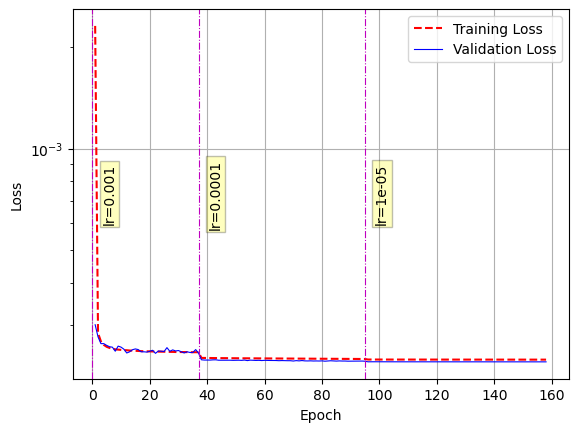

In [51]:
# plotting losses

# Visualize loss history
fig, ax = plot_losses(
    training_loss=train_loss_hist,
    val_loss=val_loss_hist,
    lr_change=lr_change,
    learning_rate_list=learning_rate_list
)

plt.savefig(dir_name_ae+'{ds}plots{ds}loss_history.png'.format(ds=dir_sep), dpi=300, bbox_inches='tight')
plt.show()


In [52]:
reconstructed_data = ae_net.predict(all_data)

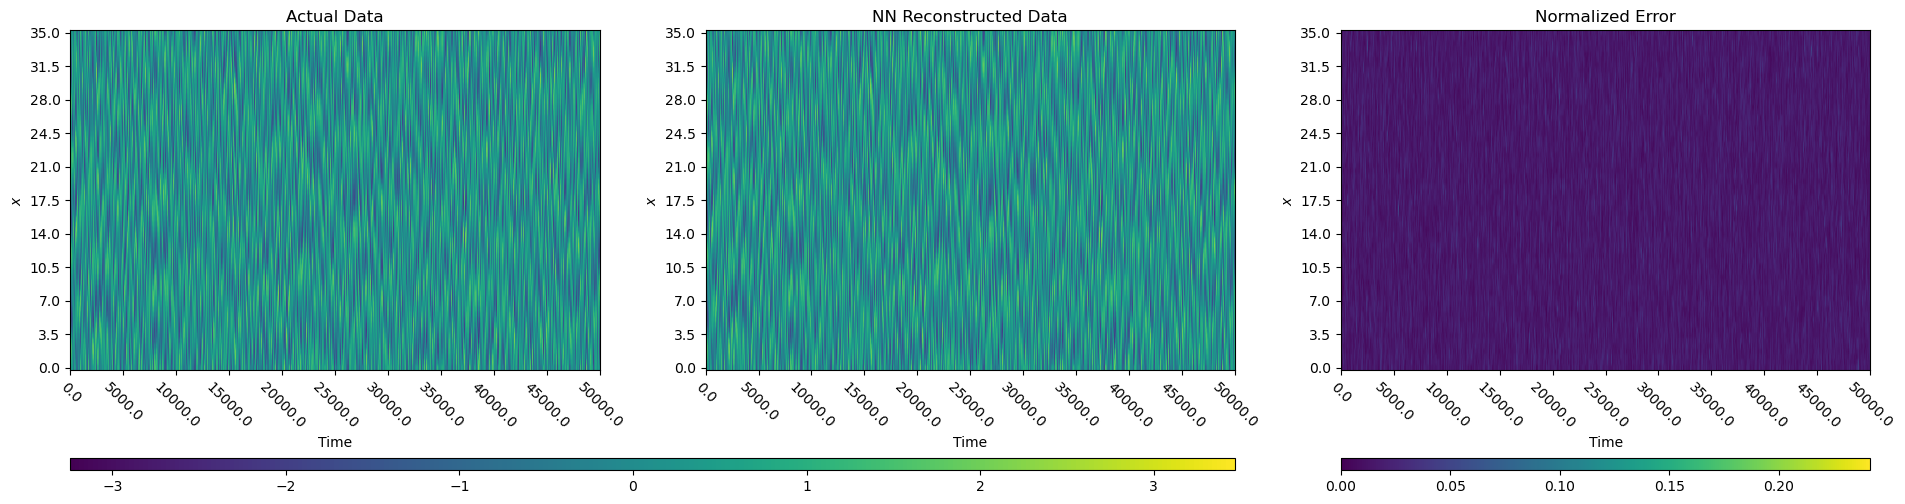

In [53]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=False,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [54]:
plot_reconstructed_data_KS(
    boundary_idx_arr,
    dir_name_ae,
    all_data,
    reconstructed_data, delta_t, xgrid,
    save_figs=True,
    normalization_constant_arr=normalization_constant_arr_aedata,
    xticks_snapto=xticks_snapto,
    num_yticks=11)

In [55]:
# create data
latent_states_all = ae_net.encoder_net.predict(all_data)

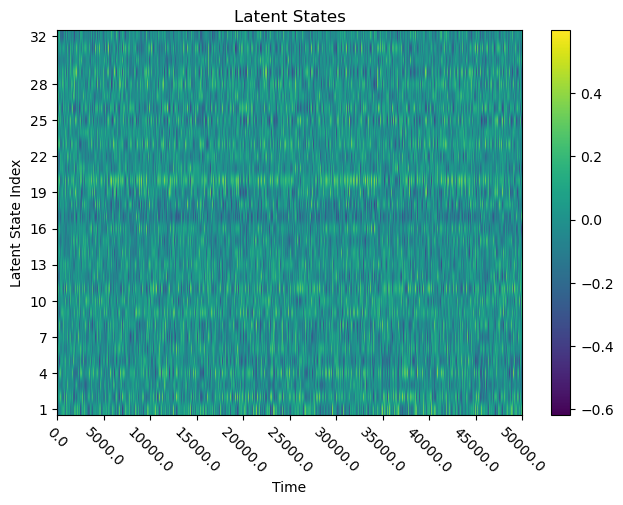

In [56]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=False)

In [57]:
plot_latent_states_KS(
    boundary_idx_arr,
    latent_states_all,
    delta_t,
    dir_name_ae,
    xticks_snapto=xticks_snapto,
    num_yticks=11,
    save_figs=True)

In [58]:
# ae_net.summary()

# KE and Dissipation

In [59]:
save_dir = dir_name_ae+dir_sep+'plots'
# save_dir = None

In [60]:
# Time evolution of Kinetic Energy
KE_org_list = []
KE_reconstructed_list = []
KE_nrmse = []

if normalizeforae_flag == True:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]#.copy()
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]#.copy()
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_aedata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_aedata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_aedata[0, i]
else:
    rescaled_org_data = all_data[:, 0:xgrid.shape[0]]
    rescaled_recon_data = reconstructed_data[:, 0:xgrid.shape[0]]

if normalize_flag_ogdata == True:
    for i in range(xgrid.shape[0]):
        rescaled_org_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_org_data[:, i] += normalization_constant_arr_ogdata[0, i]
        rescaled_recon_data[:, i] *= normalization_constant_arr_ogdata[1, i]
        rescaled_recon_data[:, i] += normalization_constant_arr_ogdata[0, i]

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    KE_org = np.sum(rescaled_org_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_org += 0.5*(rescaled_org_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_org /= xgrid.shape[0]-1
    KE_org_list.append(KE_org)
    
    KE_recon = np.sum(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 1:-1]**2, axis=1)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], 0]**2)
    KE_recon += 0.5*(rescaled_recon_data[begin_idx:boundary_idx_arr[i], -1]**2)
    KE_recon /= xgrid.shape[0]-1
    KE_reconstructed_list.append(KE_recon)

    KE_rmse = np.mean((KE_recon - KE_org)**2)**0.5
    KE_mean = np.mean(KE_org)
    KE_rmse_normalized = KE_rmse/KE_mean
    KE_nrmse.append(KE_rmse_normalized)
    
    print('Case {} - KE_nrmse : {}'.format(i+1, KE_rmse_normalized))

    begin_idx = boundary_idx_arr[i]

Case 1 - KE_nrmse : 0.02034225686378045


In [61]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1

num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    print(lyap_time)
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time

    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    # prev_idx = boundary_idx_arr[i] - (next_idx-prev_idx)
    # next_idx = boundary_idx_arr[i]
    
    ax.plot(input_time, KE_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, KE_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$KE$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    # ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )
    
    # plt.colorbar(im)
    if save_dir is not None:
        fig.savefig(save_dir+dir_sep+'KE-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

15.466301


In [62]:
def compute_laplace_operator(
        data,
        xgrid
    ):
    from scipy.fft import fft, ifft, fftfreq
    M = xgrid.shape[0]
    length = xgrid[-1]
    k = fftfreq(M) * M * 2*np.pi/length
    laplace_operated_data = data[:, 0:M].copy()
    for i in range(data.shape[0]):
        v = fft(data[i, 0:M])
        v = k*k*v
        laplace_operated_data[i, :] = np.real(ifft(v))
    return laplace_operated_data

In [63]:
# Time evolution of Dissipation
D_org_list = []
D_reconstructed_list = []
D_nrmse = []

begin_idx = 0
for i in range(len(boundary_idx_arr)):
    temp = compute_laplace_operator(rescaled_org_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_org = np.sum(temp[:, 1:-1]**2, axis=1)
    D_org += 0.5*(temp[:, 0]**2)
    D_org += 0.5*(temp[:, -1]**2)
    D_org /= xgrid.shape[0]-1
    D_org_list.append(D_org)
    
    temp = compute_laplace_operator(rescaled_recon_data[begin_idx:boundary_idx_arr[i]], xgrid)
    D_recon = np.sum(temp[:, 1:-1]**2, axis=1)
    D_recon += 0.5*(temp[:, 0]**2)
    D_recon += 0.5*(temp[:, -1]**2)
    D_recon /= xgrid.shape[0]-1
    D_reconstructed_list.append(D_recon)
    
    D_rmse = np.mean((D_recon - D_org)**2)**0.5
    D_mean = np.mean(D_org)
    D_rmse_normalized = D_rmse/D_mean
    D_nrmse.append(D_rmse_normalized)
    
    print('Case {} - D_nrmse : {}'.format(i+1, D_rmse_normalized))
    
    begin_idx = boundary_idx_arr[i]

Case 1 - D_nrmse : 0.021815228675105783


In [64]:
n = len(boundary_idx_arr)
num_digits_n = int(np.log10(n)+1)

# '''
num_cols = 1
num_rows = 1
factor = 1
num_modes = xgrid.shape[0]

prev_idx = 0
for i in range(n):
    lyap_time = lyapunov_time_arr[i]
    start_time = 0
    plot_time = 20*lyap_time
    # next_idx = boundary_idx_arr[i]
    prev_idx += int((start_time + 0.5*delta_t)//delta_t) 
    next_idx = prev_idx + int((plot_time+0.5*delta_t)//delta_t)
    fig, ax = plt.subplots(figsize=(factor*7.5*num_cols, factor*5.0*num_rows))
    N = next_idx - prev_idx
    # print(N)
    input_time = (start_time + np.arange(0, N)*delta_t)/lyap_time
    
    # temp = N*delta_t
    # chosen_interval = temp//10
    # sn = np.format_float_scientific(chosen_interval, exp_digits=4)
    # # print(temp, sn)
    # snap = 25*np.round(10*float(sn[0:-6])/25)/10
    # if snap == 0:
    #     snap = 0.1
    # snap *= float('1'+sn[-6:])
    # xticks_snapto = int(snap*np.round(chosen_interval/snap))

    ax.plot(input_time, D_org_list[i][prev_idx:next_idx], color='k', label='Original Data')
    ax.plot(input_time, D_reconstructed_list[i][prev_idx:next_idx], color='C0', label='Reconstructed Data')
    # num_xticks = 1 + int((N*delta_t + 0.5*xticks_snapto) // xticks_snapto)
    # xticks = np.linspace(0, N, num_xticks, dtype=np.int32)
    # xticks = int((start_time + 0.5*delta_t)//delta_t) + np.arange(0, N+1, int((xticks_snapto+0.5*delta_t)//delta_t))
    # print(xticks)
    # ax.set_xticks(ticks=np.round(xticks*delta_t, 1))
    # ax.set_xticklabels(np.round(xticks*delta_t, 1))
    ax.tick_params(axis='x', rotation=270+45)

    # yticks = np.linspace(0, 1, 10+1)*(len(xgrid)-1)
    # yticklabels = np.round(np.linspace(0, 1, yticks.shape[0])*xgrid[-1], 2)
    # ax.set_yticks(ticks=yticks)
    # ax.set_yticklabels(yticklabels)

    ax.set_xlabel(r'Time$^+$')
    ax.set_ylabel(r'$D$')
    ax.grid(True)
    ax.legend()
    # ax.title.set_text(r'Latent States')
    # if ax_titles_list is not None:
    #     ax.title.set_text(ax_titles_list[i])
    # else:
    ax.title.set_text(r'Case '+str(i+1))

    text_xy = [0.05, 0.05]
    ax.text(
        text_xy[0],
        text_xy[1],
        'latent space dimensions : {}'.format(
            latent_states_all.shape[1],
        ),
        transform=ax.transAxes,
        bbox=dict(
            boxstyle="round",
            ec=(0.6, 0.6, 1),
            fc=(0.9, 0.9, 1),
            alpha=0.8
        ),
        # bbox=dict(facecolor='C0', alpha=0.5, boxstyle='round,pad=0.2'),
        horizontalalignment='left',
        verticalalignment='bottom'
    )

    if save_dir is not None:
        fig.savefig(save_dir+'/Dissipation-Case_'+str(i+1).zfill(num_digits_n)+'.png', dpi=300, bbox_inches='tight')
        fig.clear()
        plt.close()
    else:
        plt.show()
        print('')

    prev_idx = next_idx

In [65]:
np.savez(
    dir_name_ae+dir_sep+'KE_D_data',
    KE_org_list=KE_org_list,
    KE_reconstructed_list=KE_reconstructed_list,
    KE_nrmse=KE_nrmse,
    D_org_list=D_org_list,
    D_reconstructed_list=D_reconstructed_list,
    D_nrmse=D_nrmse,
    num_latent_states=[latent_states_all.shape[1]],
)

In [66]:
# x = np.linspace(-5, 5, 100)

# a = 1 #- np.exp(-2)

# modified_relu = lambda x : tf.keras.activations.relu(x+a).numpy()-a
# elu = lambda x : tf.keras.activations.elu(x)

# y1 = modified_relu(x)
# y2 = elu(x)

# plt.plot(x, y1, label='modified_relu')
# plt.plot(x, y2, label='elu')
# plt.legend()
# plt.grid(True)
# plt.show()

In [67]:
ae_net.decoder_layers_list[-1].weights

[<tf.Variable 'single_weights_1/individual_weights:0' shape=(64,) dtype=float32, numpy=
 array([1.3819299, 1.3873055, 1.3854176, 1.3686068, 1.3706869, 1.3785926,
        1.3815547, 1.3981233, 1.39874  , 1.3877409, 1.3858483, 1.3842534,
        1.3845065, 1.3791997, 1.371035 , 1.3821228, 1.3769412, 1.369095 ,
        1.3680981, 1.3645301, 1.3700564, 1.3596349, 1.3744875, 1.373777 ,
        1.3709679, 1.3778799, 1.3691736, 1.3799886, 1.3779951, 1.3792553,
        1.3746458, 1.3777151, 1.37368  , 1.369924 , 1.3698558, 1.3597037,
        1.3829439, 1.3787082, 1.3759764, 1.384179 , 1.3634135, 1.3672224,
        1.3710923, 1.3734175, 1.3792535, 1.3783028, 1.3752618, 1.3641007,
        1.3668447, 1.3661569, 1.3731799, 1.3940762, 1.3877912, 1.389022 ,
        1.3849828, 1.3835247, 1.378787 , 1.376411 , 1.3832608, 1.3759327,
        1.3781708, 1.3700846, 1.3700291, 1.3817296], dtype=float32)>]